### Verificación empírica de la complejidad algorítmica
Teoricamente llegamos a que el algoritmo tiene una complejidad de O(n^2).

A continuación se intentará verificar esto de manera empírica, generando un volumen de situaciones aleatorias con tamaño incremental, observando si el tiempo de resolución incrementa de forma cuadratica.  

In [1]:
# Imports necesarios para el notebook
from random import seed

from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import sys

In [2]:
# Funciones de utilidad
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 20

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = 10


def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [3]:
sys.setrecursionlimit(300000)
def decision_mateo(arr, inicio = 0, fin = 0):
    if arr[inicio] > arr[fin - 1]:
        return (inicio + 1, fin)
    return (inicio, fin - 1)

def _juego_monedas(arr, inicio = 0, fin = 0, memory = {}):
    if inicio >= fin:
        return 0
    
    key = (inicio, fin)
    if key in memory:
        return memory[key]

    primer_moneda = arr[inicio]
    ultima_moneda = arr[fin-1]
    
    decision_mateo_1 = decision_mateo(arr, inicio + 1, fin)
    decision_mateo_2 = decision_mateo(arr, inicio, fin-1)

    ganancia = max(primer_moneda + _juego_monedas(arr,decision_mateo_1[0],decision_mateo_1[1], memory), 
                   ultima_moneda + _juego_monedas(arr, decision_mateo_2[0], decision_mateo_2[1], memory))
    
    # guardamos la respuesta en la memoria
    memory[key] = ganancia

    return ganancia

# Dado un arreglo de monedas, devuelve la ganancia maxima de Sofia y la memoria de las llamadas recursivas.
def juego_monedas(arr):
    memory = {}
    return _juego_monedas(arr, 0, len(arr), memory), memory


In [4]:
def get_random_array(size: int):
    return np.random.randint(0, 100.000, size)

# La variable x van a ser los valores del eje x de los gráficos en todo el notebook
# Tamaño mínimo=100, tamaño máximo=1k, cantidad de puntos=40
x = np.linspace(10, 1_000, 40).astype(int)


results = time_algorithm(juego_monedas, x, lambda s: [get_random_array(s)])

### Ejecutamos el algoritmo para casos aleatorios de hasta 10 mil elementos, se observa el siguiente crecimiento:

Text(0, 0.5, 'Tiempo de ejecución (s)')

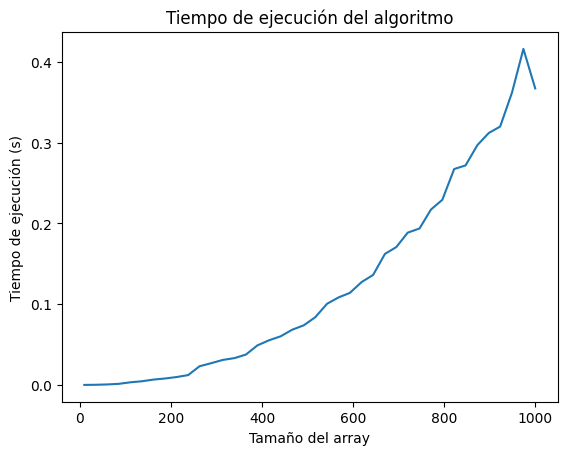

In [5]:
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución del algoritmo')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Tiempo de ejecución (s)')

In [6]:
### Luego calculamos el error cuadratico :

In [7]:
f = lambda x, c1, c2, c3: c1 * x**2 + c2 * x + c3

c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}, c_3 = {c[2]}")
r = np.sum((c[0] * x**2 + c[1] * x + c[2] - np.array([results[n] for n in x]))**2)
print(f"Error cuadrático medio: {r/len(results)}")

c_1 = 4.862210931151572e-07, c_2 = -9.840237174460886e-05, c_3 = 0.007830624575633945
Error cuadrático medio: 9.367273977591161e-05


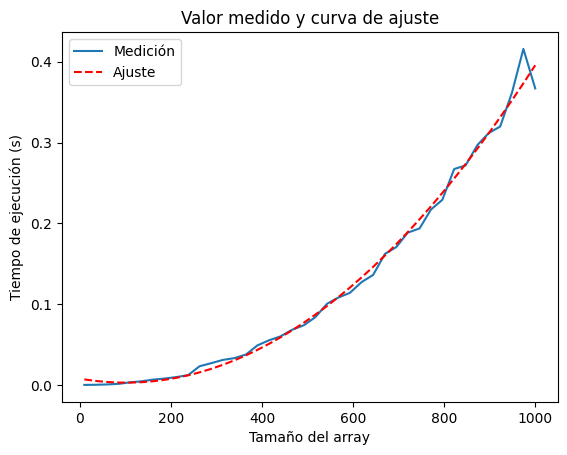

In [8]:
ax.set_title('Valor medido y curva de ajuste')
ax.plot(x, [c[0] * n**2 + c[1] * n + c[2] for n in x], 'r--', label="Ajuste")
ax.legend()
fig